In [1]:
PRFX = 'CV0919_2'

## Parameters

In [2]:
ENCODER = 'resnext101_32x8d'
ENCODER_WEIGHTS = 'instagram'
EPOCHS = 28
BS = 10

from pathlib import Path
p_out = f'../output/{PRFX}'
Path(p_out).mkdir(exist_ok=True)

## Importing libraries

In [17]:
import os
import cv2
import collections
import time 
import tqdm
import pickle
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import torch as AT

from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp

## Helper functions and classes

In [4]:
def get_img(x, folder: str='train_images'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{p_in}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
            
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)


    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)


    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)
    
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(320, 640)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640)
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

## Data overview

Let's have a look at the data first.

In [5]:
p_in = '../input'
os.listdir(p_in)

['resnet50_coco_best_v2.1.0.h5',
 'logs',
 'test_images',
 'sample_submission.csv',
 'train_images',
 'test_images.zip',
 'train.csv.zip',
 'train.csv',
 'train_images.zip',
 'keras-retinanet']

We have folders with train and test images, file with train image ids and masks and sample submission.

In [6]:
train = pd.read_csv(f'{p_in}/train.csv')
sub = pd.read_csv(f'{p_in}/sample_submission.csv')

So we have ~5.5k images in train dataset and they can have up to 4 masks: Fish, Flower, Gravel and Sugar.

But there are a lot of empty masks. In fact only 266 images have all four masks. It is important to remember this.

In [7]:
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])


sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

Let's have a look at the images and the masks.

We can see that masks can overlap. Also we can see that clouds are really similar to fish, flower and so on. Another important point: masks are often quite big and can have seemingly empty areas.

## Preparing data for modelling

At first, let's create a list of unique image ids and the count of masks for images. This will allow us to make a stratified split based on this count.

In [8]:
id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

## Exploring augmentations with albumentations

One of important things while working with images is choosing good augmentations. There are a lot of them, let's have a look at augmentations from albumentations!

This is how original image and its masks look like. Let's try adding some augmentations

## Setting up data for training in Catalyst

In [9]:
class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms = albu.Compose([albu.HorizontalFlip(),AT.ToTensor()]),
                preprocessing=None):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{p_in}/train_images"
        else:
            self.data_folder = f"{p_in}/test_images"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

Now we define model and training parameters

In [10]:
# DEVICE = 'cuda'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [11]:
num_workers = 0
bs = BS
train_dataset = CloudDataset(df=train, datatype='train', img_ids=train_ids, transforms = get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = CloudDataset(df=train, datatype='valid', img_ids=valid_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1741: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1741: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1741: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1741: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [12]:
num_epochs = EPOCHS
logdir = f"{p_out}/logs"

# model, criterion, optimizer
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])
scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
runner = SupervisedRunner()

## Model training

In [14]:
%%time
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[DiceCallback(), EarlyStoppingCallback(patience=5, min_delta=0.001)],
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

0/28 * Epoch (train): 100% 500/500 [17:41<00:00,  1.58s/it, _timers/_fps=55.137, dice=0.462, loss=0.989]
0/28 * Epoch (valid): 100% 56/56 [00:54<00:00,  1.23it/s, _timers/_fps=22.690, dice=0.278, loss=1.098]
[2019-09-20 02:53:28,140] 
0/28 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=6.8527 | _timers/batch_time=1.4925 | _timers/data_time=1.4513 | _timers/model_time=0.0411 | dice=0.3548 | loss=1.0105
0/28 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=12.4161 | _timers/batch_time=0.8195 | _timers/data_time=0.7884 | _timers/model_time=0.0311 | dice=0.4219 | loss=0.9813
1/28 * Epoch (train): 100% 500/500 [17:46<00:00,  1.51s/it, _timers/_fps=66.086, dice=0.302, loss=1.167]
1/28 * Epoch (valid): 100% 56/56 [00:54<00:00,  1.24it/s, _timers/_fps=22.753, dice=0.296, loss=1.143]
[2019-09-20 03:12:17,437] 
1/28 * Epoch 1 (train): _base/lr=0.0100 | _base/momentum=0.9000 | _timers/_fps=6.8286 | _timers/batch_time=1.5035 | _timers/data_time=1

13/28 * Epoch (train): 100% 500/500 [18:10<00:00,  1.65s/it, _timers/_fps=37.805, dice=0.292, loss=1.075]
13/28 * Epoch (valid): 100% 56/56 [00:56<00:00,  1.20it/s, _timers/_fps=22.139, dice=0.390, loss=0.931]
[2019-09-20 07:01:45,497] 
13/28 * Epoch 13 (train): _base/lr=0.0002 | _base/momentum=0.9000 | _timers/_fps=6.6046 | _timers/batch_time=1.5515 | _timers/data_time=1.5095 | _timers/model_time=0.0419 | dice=0.5014 | loss=0.7990
13/28 * Epoch 13 (valid): _base/lr=0.0002 | _base/momentum=0.9000 | _timers/_fps=11.9198 | _timers/batch_time=0.8547 | _timers/data_time=0.8234 | _timers/model_time=0.0313 | dice=0.5526 | loss=0.7391
14/28 * Epoch (train): 100% 500/500 [17:54<00:00,  1.68s/it, _timers/_fps=64.764, dice=0.488, loss=0.805]
14/28 * Epoch (valid): 100% 56/56 [00:56<00:00,  1.21it/s, _timers/_fps=22.322, dice=0.398, loss=0.892]
[2019-09-20 07:20:52,172] 
14/28 * Epoch 14 (train): _base/lr=0.0002 | _base/momentum=0.9000 | _timers/_fps=6.7535 | _timers/batch_time=1.5201 | _timers/d

In [ ]:
utils.plot_metrics(
    logdir=logdir, 
    # specify which metrics we want to plot
    metrics=["loss", "dice", 'lr', '_base/lr']
)

## Exploring predictions
Let's make predictions on validation dataset.

At first we need to optimize thresholds 

In [14]:
%%time
encoded_pixels = []
loaders = {"infer": valid_loader}
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"{logdir}/checkpoints/best.pth"),
        InferCallback()
    ],
)

=> loading checkpoint ../output/CV0919_2/logs/checkpoints/best.pth
loaded checkpoint ../output/CV0919_2/logs/checkpoints/best.pth (epoch 14)
Top best models:



In [14]:
valid_masks = []
probabilities = np.zeros((2220, 350, 525))
for i, (batch, output) in enumerate(tqdm.tqdm(zip(
        valid_dataset, runner.callbacks[0].predictions["logits"]))):
    image, mask = batch
    for m in mask:
        if m.shape != (350, 525):
            m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        valid_masks.append(m)

    for j, probability in enumerate(output):
        if probability.shape != (350, 525):
            probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        probabilities[i * 4 + j, :, :] = probability

=> loading checkpoint ../output/CV0919_2/logs/checkpoints/best.pth
loaded checkpoint ../output/CV0919_2/logs/checkpoints/best.pth (epoch 14)


2it [00:00, 12.47it/s]

Top best models:



555it [00:51, 10.83it/s]


## Find optimal values

First of all, my thanks to @samusram for finding a mistake in my validation
https://www.kaggle.com/c/understanding_cloud_organization/discussion/107711#622412

And now I find optimal values separately for each class.

In [15]:
import datetime

In [16]:
%%time
class_params = {}
for class_id in range(4):
    print('class', class_id, datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    attempts = []
    for t in range(0, 100, 5):
        if t%10==0: print(f't: {t}')
        t /= 100
        for ms in [0, 5000, 7500, 10000, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 
                   15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500]:
            masks = []
            for i in range(class_id, len(probabilities), 4):
                probability = probabilities[i]
                predict, num_predict = post_process(sigmoid(probability), t, ms)
                masks.append(predict)

            d = []
            for i, j in zip(masks, valid_masks[class_id::4]):
                if (i.sum() == 0) & (j.sum() == 0):
                    d.append(1)
                else:
                    d.append(dice(i, j))

            attempts.append((t, ms, np.mean(d)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])


    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    best_dice = attempts_df['dice'].values[0]
    
    class_params[class_id] = (best_threshold, best_size, best_dice)

class 0 2019-09-20 15:00:31
t: 0
t: 10
t: 20
t: 30
t: 40
t: 50
t: 60
t: 70
t: 80
t: 90
     threshold   size      dice
241       0.50  19500  0.620104
260       0.55  18000  0.616144
256       0.55  16000  0.615859
261       0.55  18500  0.615043
240       0.50  19000  0.615037
class 1 2019-09-20 15:15:54
t: 0
t: 10
t: 20
t: 30
t: 40
t: 50
t: 60
t: 70
t: 80
t: 90
     threshold   size      dice
211       0.45  15500  0.770076
212       0.45  16000  0.768238
230       0.50  14000  0.767819
232       0.50  15000  0.766449
231       0.50  14500  0.766405
class 2 2019-09-20 15:31:13
t: 0
t: 10
t: 20
t: 30
t: 40
t: 50
t: 60
t: 70
t: 80
t: 90
     threshold   size      dice
276       0.60  15000  0.633033
263       0.55  19500  0.632633
278       0.60  16000  0.632560
279       0.60  16500  0.632560
262       0.55  19000  0.632553
class 3 2019-09-20 15:47:29
t: 0
t: 10
t: 20
t: 30
t: 40
t: 50
t: 60
t: 70
t: 80
t: 90
     threshold   size      dice
274       0.60  14000  0.632575
239       0.

In [17]:
print(class_params)

{0: (0.5, 19500, 0.6201041093599844), 1: (0.45, 15500, 0.7700758847174316), 2: (0.6, 15000, 0.6330325806834552), 3: (0.6, 14000, 0.6325754877454395)}


In [19]:
import pickle

In [20]:
pickle.dump(class_params, open(f'{p_out}/class_params.p', 'wb'))

In [21]:
np.mean([o[2] for o in class_params.values()])

0.6639470156265777

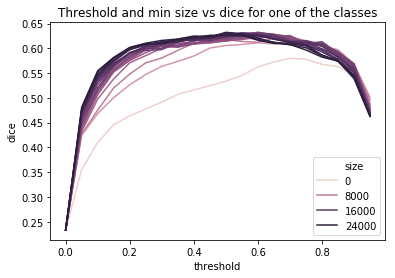

In [22]:
sns.lineplot(x='threshold', y='dice', hue='size', data=attempts_df);
plt.title('Threshold and min size vs dice for one of the classes');

Now let's have a look at our masks.

In [ ]:
for i, (input, output) in enumerate(zip(
        valid_dataset, runner.callbacks[0].predictions["logits"])):
    image, mask = input
        
    image_vis = image.transpose(1, 2, 0)
    mask = mask.astype('uint8').transpose(1, 2, 0)
    pr_mask = np.zeros((350, 525, 4))
    for j in range(4):
        probability = cv2.resize(output.transpose(1, 2, 0)[:, :, j], dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        pr_mask[:, :, j], _ = post_process(sigmoid(probability), class_params[j][0], class_params[j][1])
    #pr_mask = (sigmoid(output) > best_threshold).astype('uint8').transpose(1, 2, 0)
    
        
    visualize_with_raw(image=image_vis, mask=pr_mask, original_image=image_vis, original_mask=mask, raw_image=image_vis, raw_mask=output.transpose(1, 2, 0))
    
    if i >= 2:
        break

## Predicting

In [15]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [20]:
test_dataset = CloudDataset(df=sub, datatype='test', img_ids=test_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

loaders = {"test": test_loader}

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1741: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1741: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [18]:
class_params = pickle.load(open(f'{p_out}/class_params.p', 'rb'))

In [21]:
encoded_pixels = []
image_id = 0
for i, test_batch in enumerate(tqdm.tqdm(loaders['test'])):
    runner_out = runner.predict_batch({"features": test_batch[0].cuda()})['logits']
    for i, batch in enumerate(runner_out):
        for probability in batch:
            
            probability = probability.cpu().detach().numpy()
            if probability.shape != (350, 525):
                probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
            predict, num_predict = post_process(sigmoid(probability), class_params[image_id % 4][0], class_params[image_id % 4][1])
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                r = mask2rle(predict)
                encoded_pixels.append(r)
            image_id += 1

  0%|          | 1/463 [00:01<07:52,  1.02s/it]


RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 15.75 GiB total capacity; 14.56 GiB already allocated; 12.88 MiB free; 47.53 MiB cached)

In [ ]:
sub['EncodedPixels'] = encoded_pixels
sub.to_csv(f'{p_out}/{PRFX}_submission.csv', columns=['Image_Label', 'EncodedPixels'], index=False)

In [ ]:
sub.head()

In [ ]:
!head -n 4 {p_out}/{PRFX}_submission.csv

## references

https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools